# Crime in Washington, DC by Census Tract Characteristics - 2017

In [316]:
#! source activate GovAnalytics

In [317]:
#! pip install git+git://github.com/geopandas/geopandas.git

## Import and Prepare Data Files

##### 2017 Washington, DC Crime Data

In [42]:
import pandas as pd

#data/raw/FY2017_DCCrimeData.csv
#link_crime = 'https://github.com/qziegler/data/raw/master/raw/FY2017_DCCrimeData.csv'
link_crime = 'https://github.com/qziegler/project/data/master/data/FY2017_DCCrimeData.csv'
dc_crime = pd.read_csv(link_crime, header=0)

assert len(dc_crime) == 33070
assert len(dc_crime.columns) == 18

dc_crime.columns = map(str.lower, dc_crime.columns)

dc_crime['tract'] = dc_crime['census_tract'].astype('float64')
dc_crime.dtypes

assert dc_crime['tract'].isnull().sum() == 83
missing_tract = dc_crime['tract'].isnull().sum()

HTTPError: HTTP Error 404: Not Found

##### 2016 American Community Survey, 5-Year Estimates Race/Ethnicity Data

In [13]:
#link_race = 'https://github.com/qziegler/data/raw/master/raw/ACS_16_5YR_B03002/ACS_16_5YR_B03002_with_ann.csv'
link_race = 'https://github.com/qziegler/project/data/master/data/ACS_16_5YR_B03002/ACS_16_5YR_B03002_with_ann.csv'
census_race = pd.read_csv(link_race, header=0)

assert len(census_race) == 180
assert len(census_race.columns) == 45

census_race = census_race.drop(census_race.index[0])
census_race.rename(index=str, columns={'GEO.id':'geo_id',
                                        'GEO.id2':'geo_id2',
                                        'HD01_VD01':'total_pop',
                                        'HD01_VD03':'total_nhw',
                                        'HD01_VD04':'total_black',
                                        'HD01_VD05':'total_aian',
                                        'HD01_VD06':'total_asian',
                                        'HD01_VD07':'total_api',
                                        'HD01_VD08':'total_other',
                                        'HD01_VD09':'total_multi',
                                        'HD01_VD12':'total_hisp'}, inplace = True)

#Census variables to keep for analysis
vars = ['geo_id', 'geo_id2', 'total_pop', 'total_nhw', 'total_black', 'total_aian',
        'total_asian', 'total_api', 'total_other', 'total_multi', 'total_hisp']

HTTPError: HTTP Error 404: Not Found

Confirm race/ethnicity categories sum to 1

In [320]:
census_race['summer'] = 0
for var in vars:
    if (var != 'geo_id') & (var != 'geo_id2') & (var != 'total_pop'):
        census_race[var] = census_race[var].astype('int64')
        census_race['summer'] = census_race['summer'] + census_race[var]

census_race['total_pop'] = census_race['total_pop'].astype('int64')

In [321]:
import numpy as np
np.all(census_race['summer'] == census_race['total_pop'])

True

In [322]:
del census_race['summer']

Create tract-level shares for each race/ethnicity category

In [323]:
census_race = census_race[vars]

races = ['nhw', 'black', 'aian', 'asian', 'api', 'other', 'multi', 'hisp']

for re in races:
    census_race['share' + re] = census_race['total_' + re]/census_race['total_pop'] 
    
census_race['sharemin'] = 1 - census_race['sharenhw']

Prepare census race data for merging with crime data and merge

In [324]:
census_race['tract'] = census_race.geo_id2.str[6:]
census_race['tract'] = census_race['tract'].astype('float64')

data = pd.merge(dc_crime, census_race, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

In [325]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == missing_tract
del data['_merge']

##### 2016 American Community Survey, 5-Year Estimates Median Household Income Data

In [326]:
link_income = 'https://github.com/qziegler/data/raw/master/raw/ACS_16_5YR_S1903/ACS_16_5YR_S1903_with_ann.csv'
census_income = pd.read_csv(link_income, header=0)

assert len(census_income) == 180
assert len(census_income.columns) == 123

census_income = census_income.drop(census_income.index[0])
census_income.rename(index=str, columns={'GEO.id':'geo_id',
                                        'GEO.id2':'geo_id2',
                                        'HC02_EST_VC02':'hh_med_income',
                                        }, inplace = True)

vars = ['geo_id', 'geo_id2', 'hh_med_income']

census_income = census_income[vars]

census_income['tract'] = census_income.geo_id2.str[6:]
census_income['tract'] = census_income['tract'].astype('float64')
del census_income['geo_id']
del census_income['geo_id2']

N = len(census_income)-1
for i in range(0,N):
    try:
        float(census_income.hh_med_income[i])
    except ValueError:
        print(str('invalid float type ') + census_income.hh_med_income[i])
        
census_income['hh_med_income'].replace('-','0',inplace=True)
census_income['hh_med_income'] = census_income['hh_med_income'].astype('float64')

invalid float type -
invalid float type -
invalid float type -


Merge on census income data to main data frame

In [327]:
data = pd.merge(data, census_income, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

In [328]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == missing_tract
del data['_merge']

##### 2016 American Community Survey, 5-Year Estimates Unemployment Rate for Individuals 16 Years of Age and Older Data

In [329]:
link_employment = 'https://github.com/qziegler/data/raw/master/raw/ACS_16_5YR_S2301/ACS_16_5YR_S2301_with_ann.csv'
census_employment = pd.read_csv(link_employment, header=0)

assert len(census_employment) == 180
assert len(census_employment.columns) == 283

census_employment = census_employment.drop(census_employment.index[0])
census_employment.rename(index=str, columns={'GEO.id':'geo_id',
                                             'GEO.id2':'geo_id2',
                                             'HC04_EST_VC01':'unemp_rate',
                                             }, inplace = True)

vars = ['geo_id', 'geo_id2', 'unemp_rate']

census_employment = census_employment[vars]

census_employment['tract'] = census_employment.geo_id2.str[6:]
census_employment['tract'] = census_employment['tract'].astype('float64')
del census_employment['geo_id']
del census_employment['geo_id2']

N = len(census_employment)-1
for i in range(0,N):
    try:
        float(census_employment.unemp_rate[i])
    except ValueError:
        print(str('invalid float type ') + census_employment.unemp_rate[i])

census_employment['unemp_rate'] = census_employment['unemp_rate'].astype('float64')
census_employment['unemp_rate'] = census_employment['unemp_rate']/100

Merge on census unemployment data to main data frame

In [330]:
data = pd.merge(data, census_employment, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

In [331]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == missing_tract
del data['_merge']

###### 2016 American Community Survey, 5-Year Estimates Occupancy Status Data

In [332]:
link_occupancy = 'https://github.com/qziegler/data/raw/master/raw/ACS_16_5YR_B25002/ACS_16_5YR_B25002_with_ann.csv'
census_occupancy = pd.read_csv(link_occupancy, header=0)

assert len(census_occupancy) == 180
assert len(census_occupancy.columns) == 9

census_occupancy = census_occupancy.drop(census_occupancy.index[0])
census_occupancy.rename(index=str, columns={'GEO.id':'geo_id',
                                            'GEO.id2':'geo_id2',
                                            'HD01_VD01':'total_units',
                                            'HD01_VD02':'total_occupied',
                                            'HD01_VD03':'total_vacant',
                                             }, inplace = True)

vars = ['geo_id', 'geo_id2', 'total_units', 'total_occupied', 'total_vacant']

census_occupancy = census_occupancy[vars]

census_occupancy['tract'] = census_occupancy.geo_id2.str[6:]
census_occupancy['tract'] = census_occupancy['tract'].astype('float64')
del census_occupancy['geo_id']
del census_occupancy['geo_id2']

N = len(census_occupancy)-1
for i in range(0,N):
    for var in 'total_units', 'total_occupied', 'total_vacant':
        try:
            float(census_occupancy[var].iloc[i])
        except ValueError:
            print(str('invalid float type ') + census_occupancy[var].iloc[i])

for var in 'total_units', 'total_occupied', 'total_vacant':
    census_occupancy[var] = census_occupancy[var].astype('float64')
    
census_occupancy['vacancy_rate'] = census_occupancy['total_vacant']/census_occupancy['total_units']

census_occupancy = census_occupancy[['tract', 'vacancy_rate']]

Merge on census vacancy rate data

In [333]:
data = pd.merge(data, census_occupancy, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

In [334]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == missing_tract
del data['_merge']

##### Review and set data types

In [335]:
print(data.dtypes)

cat_vars = ['offense', 'method']
for var in cat_vars:
    data[var] = data[var].astype('category')
    
data['hh_med_income'].replace(0,np.nan,inplace=True)

report_dat               object
shift                    object
offense                  object
method                   object
block                    object
district                float64
psa                     float64
ward                      int64
anc                      object
neighborhood_cluster     object
block_group              object
census_tract            float64
voting_precinct          object
ccn                       int64
xblock                  float64
yblock                  float64
start_date               object
end_date                 object
tract                   float64
geo_id                   object
geo_id2                  object
total_pop               float64
total_nhw               float64
total_black             float64
total_aian              float64
total_asian             float64
total_api               float64
total_other             float64
total_multi             float64
total_hisp              float64
sharenhw                float64
sharebla

## Data Review

###### Investigate Offense Type

In [336]:
print(data['offense'].value_counts()) 

THEFT/OTHER                   14448
THEFT F/AUTO                  10256
MOTOR VEHICLE THEFT            2411
ROBBERY                        2170
ASSAULT W/DANGEROUS WEAPON     1851
BURGLARY                       1525
SEX ABUSE                       290
HOMICIDE                        115
ARSON                             4
Name: offense, dtype: int64


In [337]:
print(data['offense'].describe())
data['offense'].mode() == "THEFT/OTHER" 

count           33070
unique              9
top       THEFT/OTHER
freq            14448
Name: offense, dtype: object


0    True
Name: offense, dtype: bool

In [338]:
from scipy.stats import chisquare
print(chisquare(data['offense'].value_counts()))

Power_divergenceResult(statistic=56821.474206229213, pvalue=0.0)


Split by property crime vs. violent crime

Text(0,0.5,u'Count')

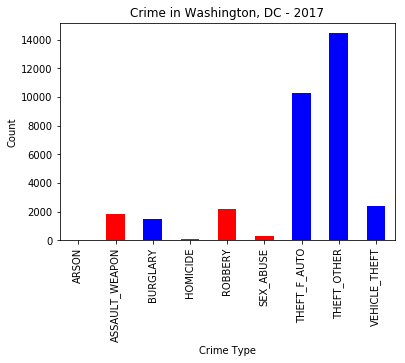

In [339]:
data['offense'].replace('ASSAULT W/DANGEROUS WEAPON', 'ASSAULT_WEAPON', inplace=True)
data['offense'].replace('MOTOR VEHICLE THEFT', 'VEHICLE_THEFT', inplace=True)
data['offense'].replace('SEX ABUSE', 'SEX_ABUSE', inplace=True)
data['offense'].replace('THEFT F/AUTO', 'THEFT_F_AUTO', inplace=True)
data['offense'].replace('THEFT/OTHER', 'THEFT_OTHER', inplace=True)

crimes = ['ARSON', 'ASSAULT_WEAPON', 'BURGLARY', 'HOMICIDE', 'VEHICLE_THEFT',
          'ROBBERY', 'SEX_ABUSE', 'THEFT_F_AUTO', 'THEFT_OTHER']

for crime in crimes:
    crime_flag=lambda x:1 if x==crime else 0
    data[crime] = data['offense'].map(crime_flag)
    
data.columns = map(str.lower, data.columns)
    
data['property_crime'] =  data['burglary'] + data['vehicle_theft'] + data['theft_f_auto'] + data['theft_other']
data['violent_crime'] = data['arson'] + data['assault_weapon'] + data['homicide'] + data['robbery'] + data['sex_abuse']

data['offense'] = data['offense'].astype('category')
categories = data['offense'].cat.categories
property_crimes = ['BURGLARY','VEHICLE_THEFT','THEFT_F_AUTO','THEFT_OTHER']

palette = ['b' if (x in property_crimes) else 'r' for x in categories]

import matplotlib.pyplot as plt
data['offense'].value_counts(sort=False).plot.bar(color=palette, title="Crime in Washington, DC - 2017")
plt.xlabel('Crime Type')
plt.ylabel('Count')

##### Explore relationship between Offense Type and Method

In [340]:
print(data['method'].value_counts())

OTHERS    30666
GUN        1583
KNIFE       821
Name: method, dtype: int64


In [341]:
pd.crosstab(data['offense'], data['method'], normalize='index', margins=True)

method,GUN,KNIFE,OTHERS
offense,,,
ARSON,0.000000,0.000000,1.000000
ASSAULT_WEAPON,0.368449,0.349541,0.282010
BURGLARY,0.001967,0.000656,0.997377
HOMICIDE,0.756522,0.078261,0.165217
ROBBERY,0.368664,0.068664,0.562673
SEX_ABUSE,0.037931,0.044828,0.917241
THEFT_F_AUTO,0.000000,0.000000,1.000000
THEFT_OTHER,0.000000,0.000138,0.999862
VEHICLE_THEFT,0.000000,0.000000,1.000000


In [342]:
from scipy import stats
chi,p,df,expected = stats.chi2_contingency(observed=pd.crosstab(data['offense'], data['method']))
if p > 0.05:
    print('Offense type and method are independent')
else:
    print('Offense type and method are not independent')

Offense type and method are not independent


Text(0.5,1,u'Share of Crimes Commited by Given Method')

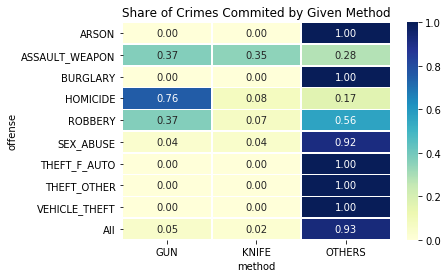

In [343]:
table=pd.crosstab(data['offense'], data['method'],normalize='index',margins=True)
import seaborn as sns
ax=sns.heatmap(table,yticklabels=True,linewidths=.5,annot=True,fmt='.2f',cmap="YlGnBu")
ax.set_title('Share of Crimes Commited by Given Method')

##### Explore relationship between Offense Type and race/ethnicity demographics of census tracts

In [344]:
nhw   = (pd.pivot_table(data, values='sharenhw', index='offense', aggfunc='mean', margins=True))
black = (pd.pivot_table(data, values='shareblack', index='offense', aggfunc='mean', margins=True))
hisp  = (pd.pivot_table(data, values='sharehisp', index='offense', aggfunc='mean', margins=True))

pd.concat([nhw, black, hisp],1)

,sharenhw,shareblack,sharehisp
offense,,,
ARSON,0.364512,0.483354,0.101884
ASSAULT_WEAPON,0.182556,0.702312,0.073039
BURGLARY,0.286851,0.573259,0.086401
HOMICIDE,0.120979,0.793151,0.058967
ROBBERY,0.256445,0.600372,0.090765
SEX_ABUSE,0.276950,0.588118,0.078871
THEFT_F_AUTO,0.384250,0.441490,0.104020
THEFT_OTHER,0.407862,0.427941,0.091662
VEHICLE_THEFT,0.254021,0.617108,0.080129


On average, crimes occured in census tracts that were 36% non-Hispanic white, 48% African American, and 9% Hispanic.
For comparison, homicides on average occured in census tracts that were 12% non-Hispanic white, 79% African American, and 6% Hispanic.

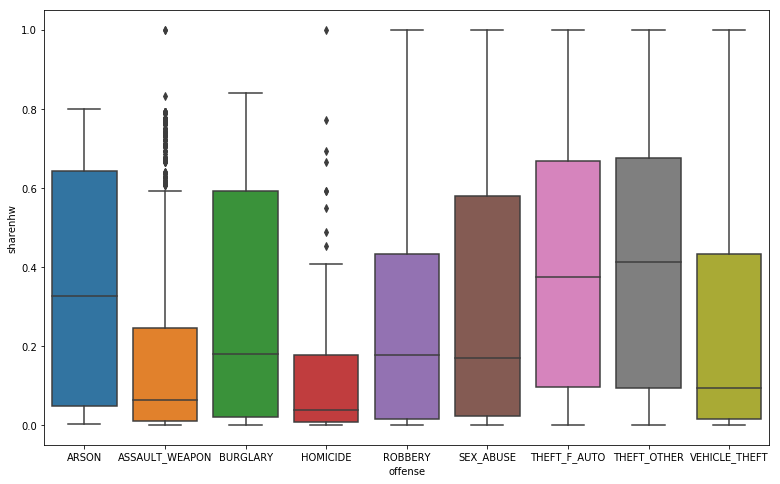

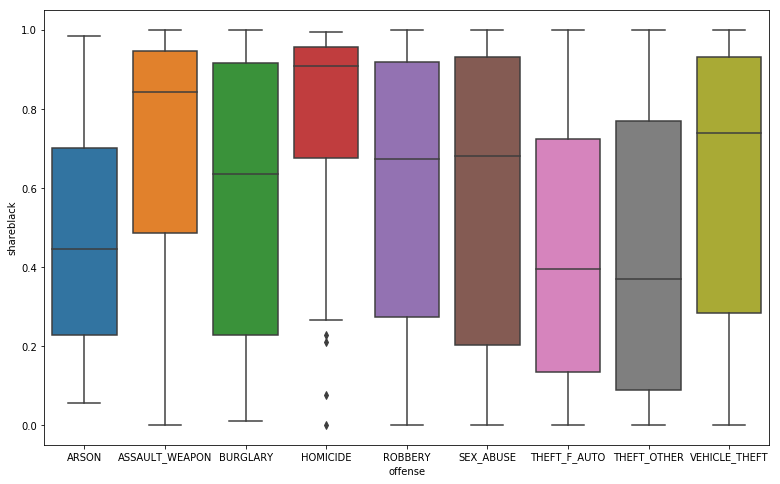

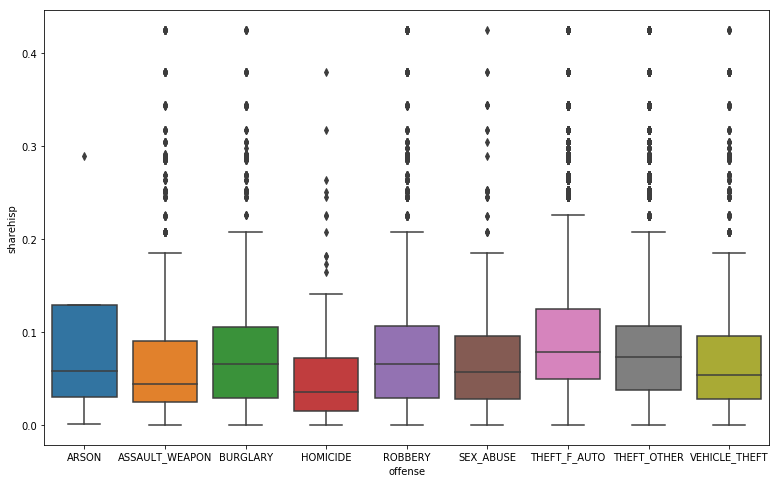

In [345]:
from matplotlib import pyplot

for race in 'sharenhw', 'shareblack', 'sharehisp':
    mydims = (13,8)
    fig, ax = pyplot.subplots(figsize=mydims)
    sns.boxplot(x='offense', y=race, data=data, ax=ax)

## Aggregate the Data by Census Tract

In [346]:
for i in range(0,len(crimes)):
    crimes[i] = crimes[i].lower()

print(crimes)
crimes.append('violent_crime')
crimes.append('property_crime')
vars = crimes[:]
vars.append('tract')
tractlevel_totalcrime = data[vars]
data_tract = tractlevel_totalcrime.groupby('tract').sum().reset_index()

covars = ['tract','total_pop','sharenhw','shareblack','sharehisp','sharemin','hh_med_income','unemp_rate','vacancy_rate']
data_covars = data[covars]
data_covars = data_covars.groupby('tract').first().reset_index()

data_tractlevel = pd.merge(data_tract, data_covars, on='tract', validate='1:1', indicator=True, how='left')
print(data_tractlevel['_merge'].value_counts())
del data_tractlevel['_merge']

['arson', 'assault_weapon', 'burglary', 'homicide', 'vehicle_theft', 'robbery', 'sex_abuse', 'theft_f_auto', 'theft_other']
both          179
right_only      0
left_only       0
Name: _merge, dtype: int64


Convert raw crime numbers to rate per 100,000 people.

In [347]:
for crime in crimes:
    data_tractlevel[crime+'_rate'] = (data_tractlevel[crime]/data_tractlevel['total_pop'])*100000

###### Violent crime by tract

In [352]:
print(data_tractlevel['violent_crime_rate'].describe())
len(data_tractlevel[data_tractlevel.violent_crime_rate > 5000])

count      179.000000
mean       818.939224
std       1252.006621
min          0.000000
25%        297.669084
50%        602.772755
75%        992.505898
max      15384.615385
Name: violent_crime_rate, dtype: float64


1

In [353]:
extreme_outlier = data_tractlevel[data_tractlevel.violent_crime_rate > 5000].tract
print(extreme_outlier)

79    6202.0
Name: tract, dtype: float64


In [354]:
data_tractlevel = data_tractlevel[data_tractlevel.tract != 6202.0].reset_index()

count     178.000000
mean      737.109583
std       609.101576
min         0.000000
25%       297.122490
50%       601.315806
75%       984.688426
max      3253.922138
Name: violent_crime_rate, dtype: float64


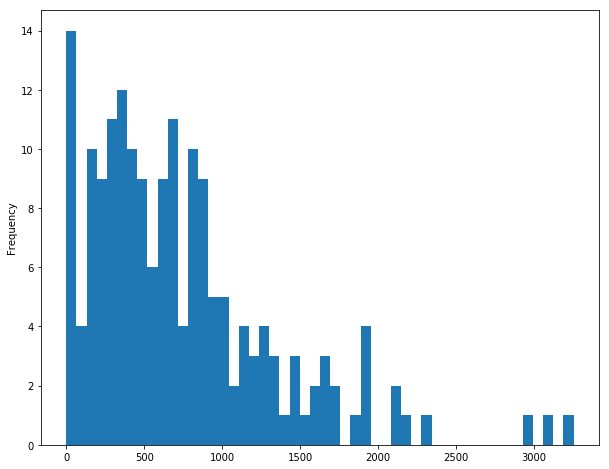

In [355]:
print(data_tractlevel['violent_crime_rate'].describe())
data_tractlevel['violent_crime_rate'].plot(kind='hist',bins=50,figsize=(10,8))

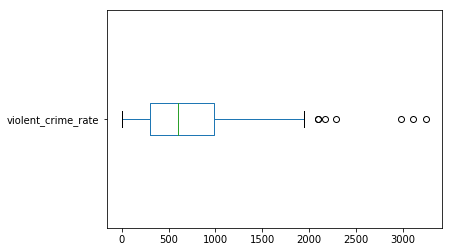

In [356]:
plot,outliers=data_tractlevel['violent_crime_rate'].plot.box(vert=False,return_type='both')

###### Investigate census tracts with high amounts of violent crime

In [358]:
len([flier.get_xdata() for flier in outliers["fliers"]][0])
[flier.get_xdata() for flier in outliers["fliers"]][0]
caps = [value.get_xdata()[0] for value in outliers["caps"]] 
lower_bound = caps[0]
upper_bound = caps[1]

outliers_vc = lambda x: 1 if (x<lower_bound) else 2 if (x>upper_bound) else np.nan if pd.isnull(x) else 0
data_tractlevel['out_vc'] = data_tractlevel['violent_crime_rate'].map(outliers_vc)


N = len(data_tractlevel)
index = list(range(0,N,1))

mylist = []
for i in index:
    if (data_tractlevel.out_vc[i]==2):
        mylist.append(data_tractlevel.tract[i])
        
outliers_table = data_tractlevel[data_tractlevel['tract'].isin(mylist)]
outliers_table = outliers_table[['tract','violent_crime','violent_crime_rate','total_pop','sharenhw','shareblack','sharehisp','sharemin','hh_med_income','unemp_rate','vacancy_rate']]
display(outliers_table)

,tract,violent_crime,violent_crime_rate,total_pop,sharenhw,shareblack,sharehisp,sharemin,hh_med_income,unemp_rate,vacancy_rate
77,5800.0,58,2094.618996,2769.0,0.627302,0.068256,0.073673,0.372698,135718.0,0.089,0.255158
95,7406.0,62,2098.849018,2954.0,0.001016,0.905890,0.074137,0.998984,30000.0,0.086,0.204947
110,7803.0,85,2292.959266,3707.0,0.015646,0.875101,0.090639,0.984354,37234.0,0.169,0.119009
111,7804.0,77,2170.848604,3547.0,0.002255,0.931773,0.049056,0.997745,45396.0,0.147,0.157420
129,8803.0,73,3114.334471,2344.0,0.232935,0.616468,0.090017,0.767065,17303.0,0.188,0.171965
150,9603.0,105,2988.047809,3514.0,0.002846,0.959306,0.027319,0.997154,40551.0,0.194,0.106219
173,10700.0,56,3253.922138,1721.0,0.774550,0.048228,0.082510,0.225450,72731.0,0.035,0.127085


In [359]:
table_outvc=pd.crosstab(data_tractlevel['tract'],data_tractlevel['out_vc'])

print(data_tractlevel['out_vc'].value_counts())
table_outvc.columns = ['normal', 'high_vc']
table_outvc.replace(0, np.nan,inplace=True)
high_vc = set(table_outvc["high_vc"].dropna().index)
high_vc

0    171
2      7
Name: out_vc, dtype: int64


{5800.0, 7406.0, 7803.0, 7804.0, 8803.0, 9603.0, 10700.0}

Property crime by tract

count      178.000000
mean      4613.677872
std       4397.624539
min         42.735043
25%       2156.938447
50%       3512.480690
75%       5584.403893
max      35933.550018
Name: property_crime_rate, dtype: float64


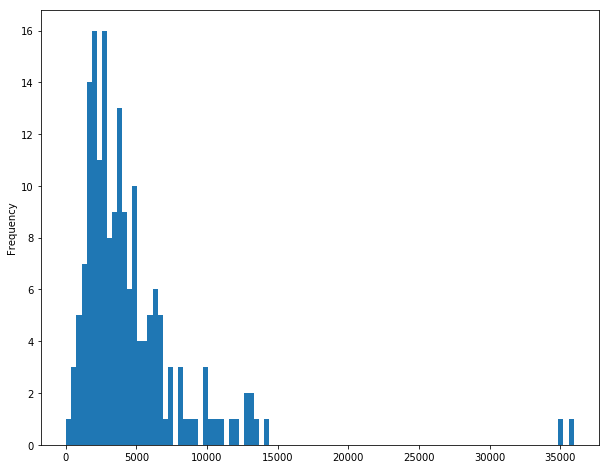

In [360]:
print(data_tractlevel['property_crime_rate'].describe())
data_tractlevel['property_crime_rate'].plot(kind='hist',bins=100,figsize=(10,8))

Investigate census tracts with high amounts of property crime

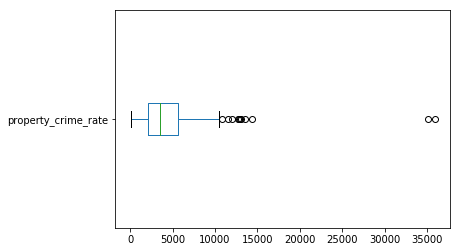

In [361]:
plot,outliers=data_tractlevel['property_crime_rate'].plot.box(vert=False,return_type='both')

In [363]:
len([flier.get_xdata() for flier in outliers["fliers"]][0])
[flier.get_xdata() for flier in outliers["fliers"]][0]
caps = [value.get_xdata()[0] for value in outliers["caps"]] 
lower_bound = caps[0]
upper_bound = caps[1]

outliers_pc = lambda x: 1 if (x<lower_bound) else 2 if (x>upper_bound) else np.nan if pd.isnull(x) else 0
data_tractlevel['out_pc'] = data_tractlevel['property_crime_rate'].map(outliers_pc)

mylist = []
for i in index:
    if (data_tractlevel.out_pc[i]==2):
        mylist.append(data_tractlevel.tract[i])
        
outliers_table = data_tractlevel[data_tractlevel['tract'].isin(mylist)]
outliers_table = outliers_table[['tract','property_crime','property_crime_rate','total_pop','sharenhw','shareblack','sharehisp','sharemin','hh_med_income','unemp_rate','vacancy_rate']]
display(outliers_table)

,tract,property_crime,property_crime_rate,total_pop,sharenhw,shareblack,sharehisp,sharemin,hh_med_income,unemp_rate,vacancy_rate
2,202.0,575,13017.885443,4417.0,0.772923,0.077202,0.065429,0.227077,161378.0,0.047,0.143706
46,3000.0,436,12991.656734,3356.0,0.410310,0.457986,0.093862,0.589690,77609.0,0.091,0.097179
63,4400.0,798,14375.788146,5551.0,0.676635,0.160692,0.055666,0.323365,154402.0,0.040,0.027788
66,4702.0,344,11965.217391,2875.0,0.484870,0.373913,0.072000,0.515130,100179.0,0.047,0.048208
77,5800.0,995,35933.550018,2769.0,0.627302,0.068256,0.073673,0.372698,135718.0,0.089,0.255158
86,6900.0,241,10855.855856,2220.0,0.704505,0.222973,0.049099,0.295495,124045.0,0.003,0.073751
129,8803.0,318,13566.552901,2344.0,0.232935,0.616468,0.090017,0.767065,17303.0,0.188,0.171965
150,9603.0,407,11582.242459,3514.0,0.002846,0.959306,0.027319,0.997154,40551.0,0.194,0.106219
167,10100.0,335,12655.836796,2647.0,0.578391,0.147337,0.106913,0.421609,87037.0,0.053,0.096774
168,10200.0,326,12774.294671,2552.0,0.413793,0.396160,0.072100,0.586207,101250.0,0.058,0.129116


In [364]:
print(data_tractlevel['out_pc'].value_counts())
table_outpc=pd.crosstab(data_tractlevel['tract'],data_tractlevel['out_pc'])

table_outpc.columns = ['normal', 'high_pc']
table_outpc.replace(0, np.nan,inplace=True)
table_outpc
high_pc = set(table_outpc["high_pc"].dropna().index)
high_pc

0    167
2     11
Name: out_pc, dtype: int64


{202.0,
 3000.0,
 4400.0,
 4702.0,
 5800.0,
 6900.0,
 8803.0,
 9603.0,
 10100.0,
 10200.0,
 10700.0}

Tracts that are outliers in both violent and property crime

In [365]:
high_vc & high_pc

{5800.0, 8803.0, 9603.0, 10700.0}

How do outlier census tracts in violent crime compare to outlier tracts in property crime?

In [367]:
assert data_tractlevel['hh_med_income'].isnull().sum() == 2
data_tractlevel_t = data_tractlevel[data_tractlevel.hh_med_income.notnull()]
assert len(data_tractlevel_t) == 176

In [368]:
for var in 'sharemin', 'hh_med_income', 'unemp_rate', 'vacancy_rate':
    print('************************')
    for type in 'out_pc', 'out_vc':
        print(pd.pivot_table(data_tractlevel, values=var, index=type, aggfunc='mean'))
        
        ttest_results = np.abs(stats.ttest_ind(data_tractlevel_t[data_tractlevel_t[type]==2][var],
                                               data_tractlevel_t[data_tractlevel_t[type]==0][var],
                                               equal_var=True))

        pval = ttest_results[1]
        if pval < 0.05:
            print('Difference in ' + var + ' is statistically significant between outliers and non-outliers')
        else:
            print('Difference in ' + var + ' is not statistically significant between outliers and non-outliers')

************************
        sharemin
out_pc          
0       0.676898
2       0.483722
Difference in sharemin is statistically significant between outliers and non-outliers
        sharemin
out_vc          
0       0.660932
2       0.763350
Difference in sharemin is not statistically significant between outliers and non-outliers
************************
        hh_med_income
out_pc               
0        77085.369697
2        97473.000000
Difference in hh_med_income is not statistically significant between outliers and non-outliers
        hh_med_income
out_vc               
0        79363.053254
2        54133.285714
Difference in hh_med_income is not statistically significant between outliers and non-outliers
************************
        unemp_rate
out_pc            
0         0.108228
2         0.076818
Difference in unemp_rate is not statistically significant between outliers and non-outliers
        unemp_rate
out_vc            
0         0.105327
2         0.129714
Dif

Scatterplots for all tracts

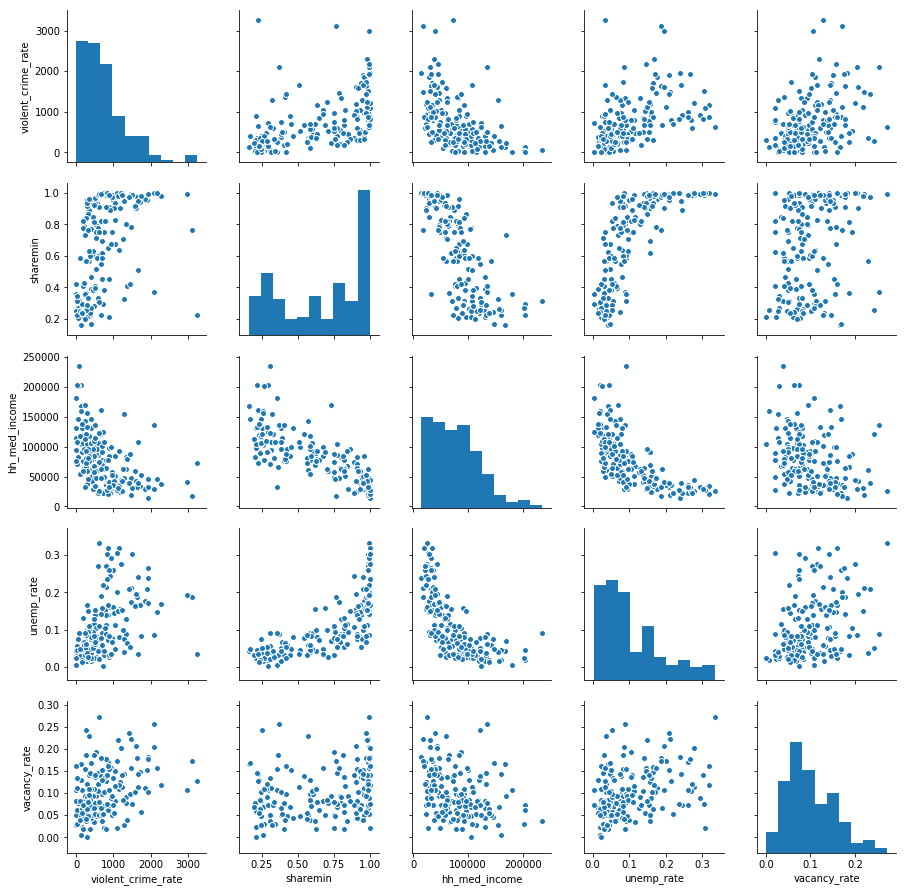

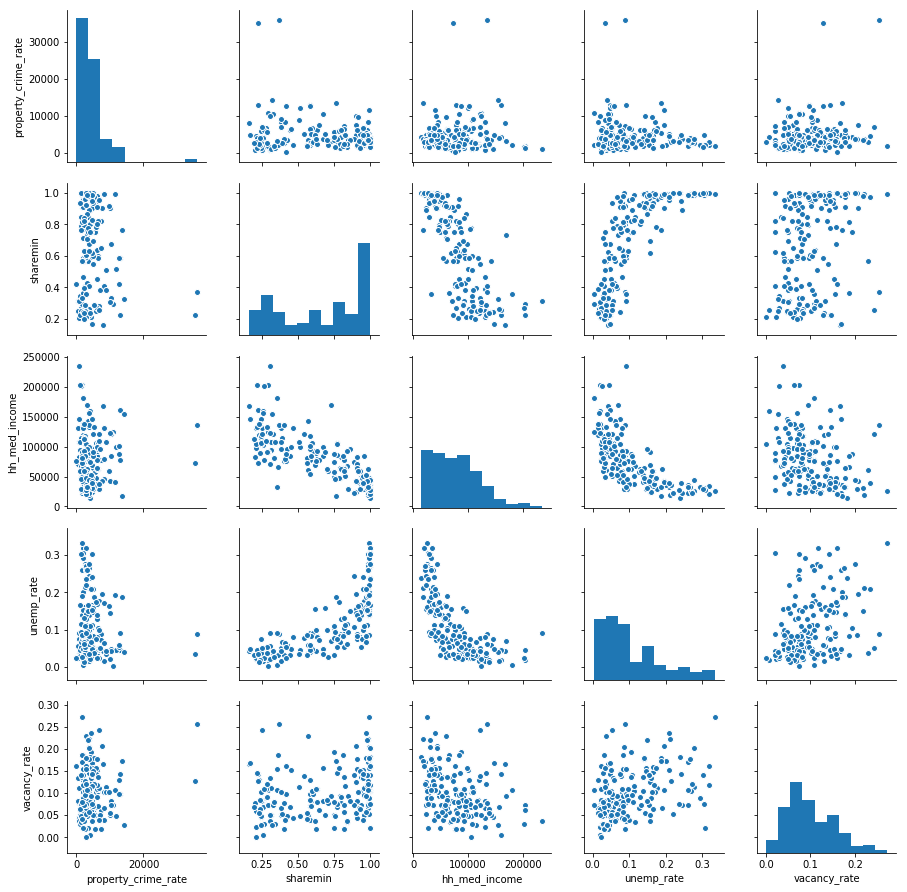

In [369]:
for crime in 'violent_crime_rate', 'property_crime_rate':
    cols=[crime, 'sharemin', 'hh_med_income', 'unemp_rate', 'vacancy_rate']
    forgraph = pd.DataFrame(data_tractlevel, columns=cols)
    sns.pairplot(forgraph.dropna())    

In [370]:
for crime in 'violent_crime_rate', 'property_crime_rate':
    cols=[crime, 'sharemin', 'hh_med_income', 'unemp_rate', 'vacancy_rate']
    forcorr = pd.DataFrame(data_tractlevel, columns=cols)
    print(forcorr.corr())
    print('*************************************************************************************')
    print('Spearman')
    print(forcorr.corr(method='spearman'))
    print('*************************************************************************************')

                    violent_crime_rate  sharemin  hh_med_income  unemp_rate  \
violent_crime_rate            1.000000  0.476352      -0.497816    0.452677   
sharemin                      0.476352  1.000000      -0.791386    0.742163   
hh_med_income                -0.497816 -0.791386       1.000000   -0.690437   
unemp_rate                    0.452677  0.742163      -0.690437    1.000000   
vacancy_rate                  0.385130  0.263442      -0.310850    0.277884   

                    vacancy_rate  
violent_crime_rate      0.385130  
sharemin                0.263442  
hh_med_income          -0.310850  
unemp_rate              0.277884  
vacancy_rate            1.000000  
*************************************************************************************
Spearman
                    violent_crime_rate  sharemin  hh_med_income  unemp_rate  \
violent_crime_rate            1.000000  0.620594      -0.594832    0.608505   
sharemin                      0.620594  1.000000      -0.84068

Violent crime is more strongly correlated with census tract demographics and household income, the unemployment rate, and vacancy rate than property crime

## Cluster Analysis

In [190]:
len(data_tractlevel.tract.unique())==len(data_tractlevel)

True

In [191]:
data_tractlevel.index = data_tractlevel.tract
data_tractlevel.loc[:,'sharemin':'vacancy_rate'].dtypes

sharemin         float64
hh_med_income    float64
unemp_rate       float64
vacancy_rate     float64
dtype: object

In [192]:
print(data_tractlevel['hh_med_income'].isnull().sum())
data_cluster = data_tractlevel.dropna()
assert len(data_cluster) == len(data_tractlevel) - 3

3


In [233]:
from sklearn import preprocessing
tract_scaled = preprocessing.scale(data_cluster.loc[:,'sharemin':'vacancy_rate'])

In [234]:
from scipy.spatial.distance import pdist, squareform
tractSimi_simple = pdist(tract_scaled,metric='euclidean')
tractSimi_matrix =squareform(tractSimi_simple)

In [235]:
from scipy.cluster.hierarchy import linkage, cut_tree
tractSimi_link = linkage(tractSimi_simple,method='average')

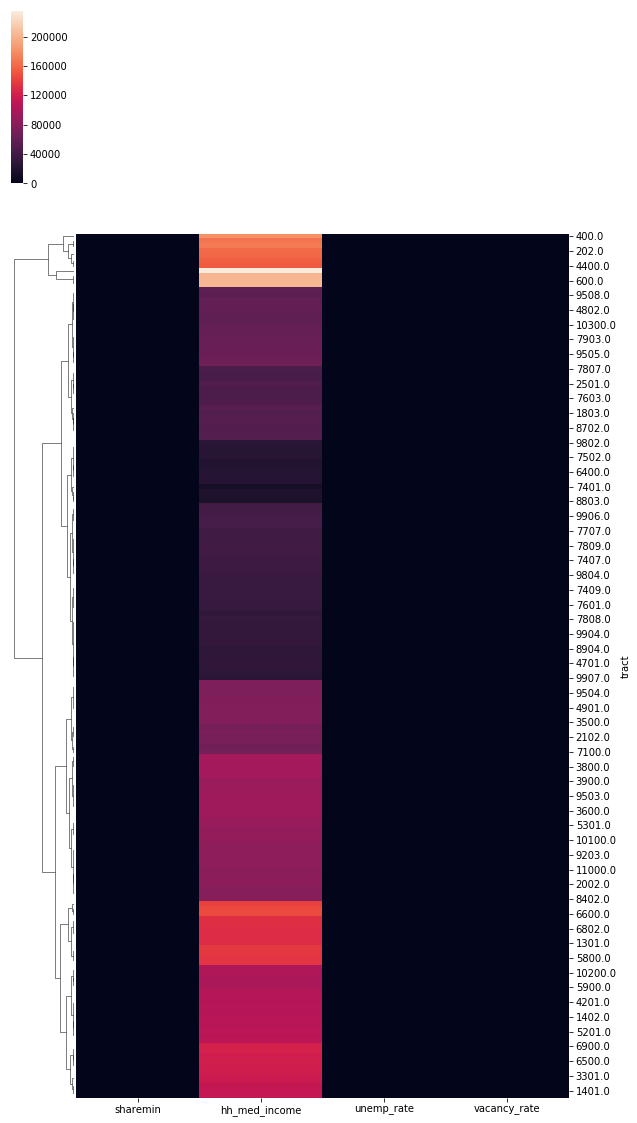

In [236]:
g = sns.clustermap(data_cluster.loc[:,'sharemin':'vacancy_rate'],
                   metric='euclidean',
                   method='average',
                   col_cluster=False,
                  figsize=(10, 20))

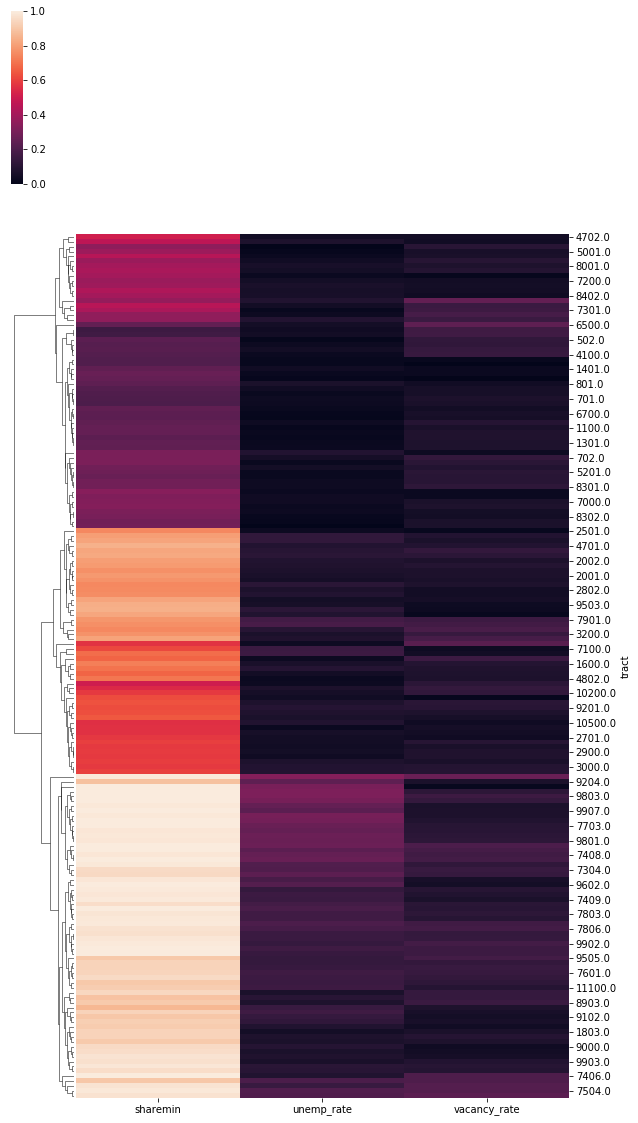

In [237]:
g_dropincome = sns.clustermap(data_cluster[['sharemin','unemp_rate','vacancy_rate']],
                   metric='euclidean',
                   method='average',
                   col_cluster=False,
                  figsize=(10, 20))

In [238]:
from sklearn.metrics import silhouette_score
from numpy import ravel

for nOfClusters in range(2,6):
    # get cluster labels
    clusterLabels = ravel(cut_tree(tractSimi_link, nOfClusters)) # formatting cut_tree output with ravel
    # get silhouettes
    silhouette_avg = silhouette_score(tractSimi_matrix,clusterLabels,metric='precomputed')
    
    # print results:
    print("For n_clusters =", nOfClusters, 
          "The average silhouette_score is:", silhouette_avg)

('For n_clusters =', 2, 'The average silhouette_score is:', 0.41878936047348331)
('For n_clusters =', 3, 'The average silhouette_score is:', 0.35819805918098652)
('For n_clusters =', 4, 'The average silhouette_score is:', 0.27515120487888134)
('For n_clusters =', 5, 'The average silhouette_score is:', 0.26560083239294952)


In [242]:
from sklearn.metrics import silhouette_samples

clusterLabels3=np.ravel(cut_tree(tractSimi_link, 3))
data_cluster['sil3']=silhouette_samples(tractSimi_matrix, clusterLabels3, metric='precomputed')

/Applications/anaconda3/envs/GovAnalytics/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [243]:
data_cluster.sil3.describe()

count    176.000000
mean       0.358198
std        0.212221
min       -0.287247
25%        0.235382
50%        0.434698
75%        0.525513
max        0.596116
Name: sil3, dtype: float64

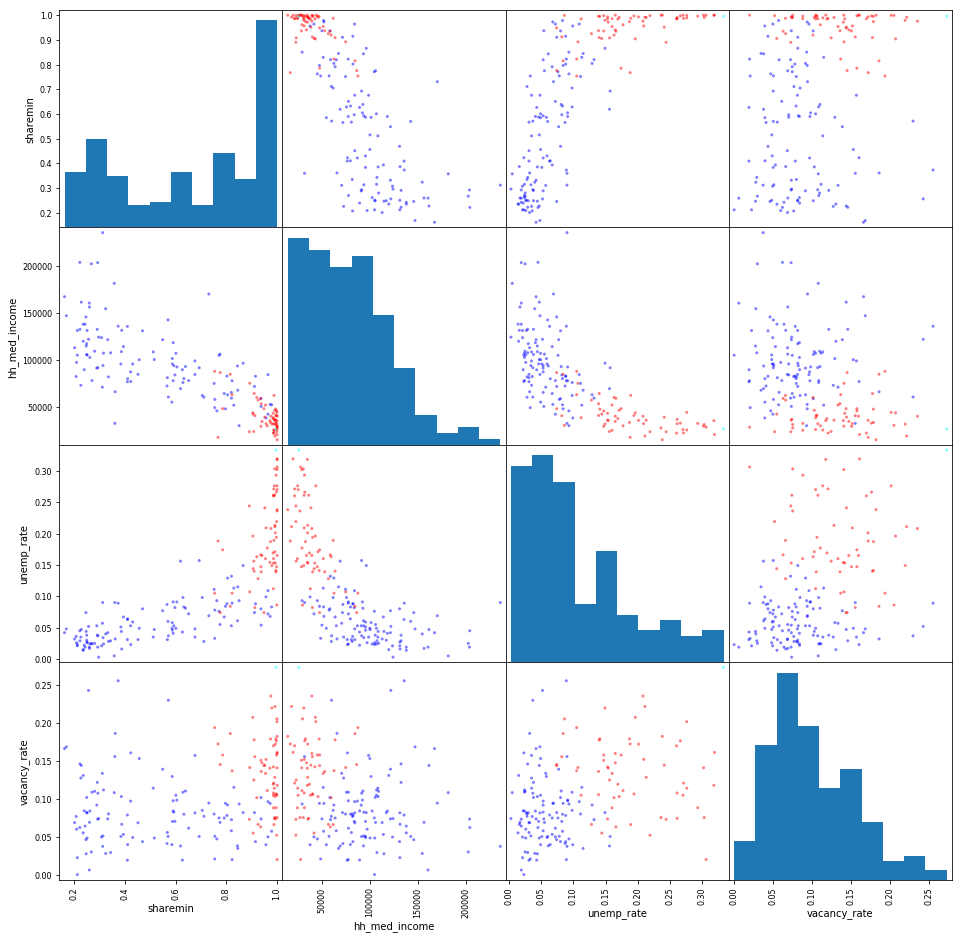

In [245]:
data_cluster.loc[:,'k3']=clusterLabels3
import matplotlib.pyplot as plt

myPalette = {0 : 'b',1 : 'r',2 : 'cyan'}      
myColors = [myPalette[l] for l in data_cluster.loc[:,'k3']]

pd.plotting.scatter_matrix(data_cluster.loc[:,'sharemin':'vacancy_rate'],
                           figsize=(16, 16),
                           c=myColors)
plt.show()

## Mapping Crime

In [46]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt

In [47]:
import pysal as ps

In [48]:
compressedwater = 'https://github.com/qziegler/data/raw/master/raw/2017_DCShapeFiles/tl_2017_11001_areawater.zip'
dcwatermap = gpd.GeoDataFrame.from_file(compressedwater)
dcwatermap.head()

,ANSICODE,HYDROID,FULLNAME,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,,110431721909,Washington Chnnl,H3010,0,860314,+38.8625888,-77.0216740,"POLYGON ((-77.03260999999999 38.882295, -77.03..."
1,,110431721799,Rock Crk,H3010,0,43194,+38.9380700,-77.0522080,"POLYGON ((-77.05220799999999 38.93807, -77.052..."
2,,110431722007,,H2030,0,746,+38.9515500,-76.9851238,"POLYGON ((-76.98543699999999 38.951356, -76.98..."
3,,110431722012,,H2030,0,428,+38.9214634,-76.9793510,"POLYGON ((-76.979541 38.92151399999999, -76.97..."
4,,110431722025,,H2030,0,94,+38.9263534,-77.1105083,"POLYGON ((-77.110562 38.926461, -77.110539 38...."


In [49]:
compressedroads = 'https://github.com/qziegler/data/raw/master/raw/2017_DCShapeFiles/tl_2017_11001_roads.zip'
dcroadmap = gpd.GeoDataFrame.from_file(compressedroads)
dcroadmap.head()

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,1104492433987,US Hwy 1 Alt,U,S1200,"LINESTRING (-76.957756 38.93074899999999, -76...."
1,1104486393160,US Hwy 1 Alt,U,S1200,"LINESTRING (-77.000573 38.89308799999999, -77...."
2,1104486393165,US Hwy 1 Alt,U,S1200,LINESTRING (-77.00057699999999 38.893403999999...
3,1104486393158,US Hwy 1 Alt,U,S1200,"LINESTRING (-76.99845399999998 38.893965, -76...."
4,1104492433988,US Hwy 1 Alt,U,S1200,"LINESTRING (-76.957667 38.93068099999999, -76...."


In [50]:
print(dcroadmap.RTTYP.value_counts())
dcroadmap = dcroadmap[dcroadmap.RTTYP != 'M']
dcroadmap = dcroadmap[dcroadmap.RTTYP != '']

M    3512
      882
U      58
I      20
S       6
Name: RTTYP, dtype: int64


In [51]:
compressedmap = 'https://github.com/qziegler/data/raw/master/raw/2017_DCShapeFiles/tl_2017_11_tract.zip'
dctractmap = gpd.GeoDataFrame.from_file(compressedmap)
dctractmap.TRACTCE = dctractmap.TRACTCE.astype('float64')
dctractmap.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,11,001,10900.0,11001010900,109,Census Tract 109,G5020,S,2379832,2936613,+38.8132450,-077.0238468,"POLYGON ((-77.039191 38.800496, -77.03913 38.8..."
1,11,001,10400.0,11001010400,104,Census Tract 104,G5020,S,2744444,83,+38.8499425,-077.0004103,"POLYGON ((-77.009191 38.839184, -77.0091549999..."
2,11,001,9903.0,11001009903,99.03,Census Tract 99.03,G5020,S,383679,0,+38.8883180,-076.9212121,"POLYGON ((-76.930054 38.88982, -76.927966 38.8..."
3,11,001,9904.0,11001009904,99.04,Census Tract 99.04,G5020,S,426198,0,+38.8851712,-076.9311353,"POLYGON ((-76.935773 38.885964, -76.935243 38...."
4,11,001,9905.0,11001009905,99.05,Census Tract 99.05,G5020,S,431557,0,+38.8843295,-076.9250522,"POLYGON ((-76.929322 38.880769, -76.92925 38.8..."


In [52]:
crimeratemap = dctractmap.merge(data_tractlevel, left_on='TRACTCE', right_on='tract', validate ='1:1', indicator=True)
crimeratemap['_merge'].value_counts()
for value in crimeratemap['_merge']:
    assert value == 'both'
    
del crimeratemap['_merge']

In [53]:
crimeratemap.violent_crime_rate.describe()
crimeratemap_dropmall = crimeratemap[crimeratemap.violent_crime_rate < 10000]

In [54]:
#! pip install descartes

### Maps - Crime Rates by Census Tract

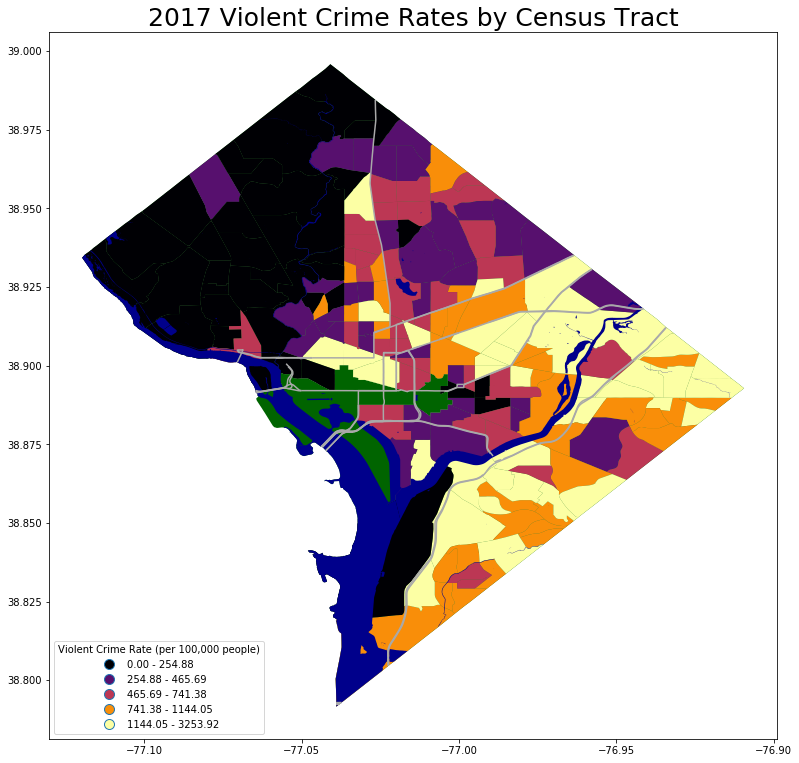

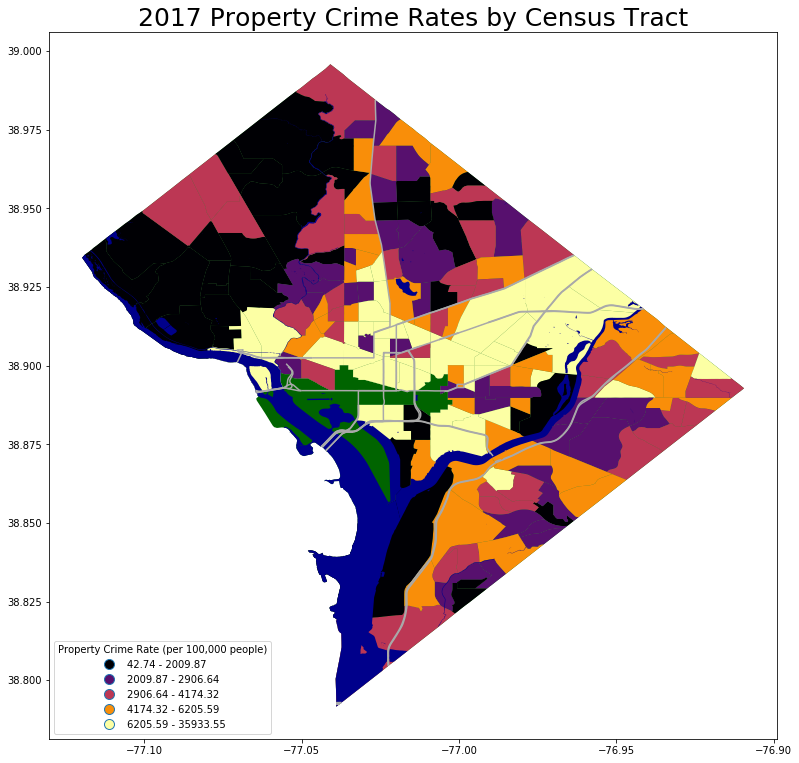

In [55]:
%matplotlib inline

for crime_type in 'violent_crime_rate', 'property_crime_rate':
    
    if crime_type == 'violent_crime_rate':
        title = '2017 Violent Crime Rates by Census Tract'
        leg_title = 'Violent Crime Rate (per 100,000 people)'
    
    if crime_type == 'property_crime_rate':
        title = '2017 Property Crime Rates by Census Tract'
        leg_title = 'Property Crime Rate (per 100,000 people)'

    base        = crimeratemap.plot(color='darkgreen',figsize=(20,13))
    crime_layer = crimeratemap_dropmall.plot(ax=base,column=crime_type,cmap='inferno',scheme='quantiles',k=5,legend=True,
                                       legend_kwds={'loc': 3,'title':leg_title})
    water_layer = dcwatermap.plot(ax=crime_layer,color='darkblue',figsize=(20,13))
    road_layer  = dcroadmap.plot(ax=water_layer,color='darkgrey',figsize=(20,13))
    road_layer.set_title(title, color='black', fontdict={'fontsize':25})

In [56]:
data.head()

,report_dat,shift,offense,method,block,district,psa,ward,anc,neighborhood_cluster,...,assault_weapon,burglary,homicide,vehicle_theft,robbery,sex_abuse,theft_f_auto,theft_other,property_crime,violent_crime
0,2/6/17 20:11,EVENING,THEFT_OTHER,OTHERS,600 - 669 BLOCK OF MARYLAND AVENUE NE,1.0,107.0,6,6C,Cluster 25,...,0,0,0,0,0,0,0,1,1,0
1,6/3/17 12:54,DAY,THEFT_F_AUTO,OTHERS,2900 - 2999 BLOCK OF N STREET NW,2.0,206.0,2,2E,Cluster 4,...,0,0,0,0,0,0,1,0,1,0
2,4/7/17 0:00,MIDNIGHT,HOMICIDE,OTHERS,5800 - 5899 BLOCK OF 4TH STREET NW,4.0,402.0,4,4B,Cluster 17,...,0,0,1,0,0,0,0,0,0,1
3,3/13/17 0:00,MIDNIGHT,HOMICIDE,OTHERS,2000 - 2099 BLOCK OF FENWICK STREET NE,5.0,506.0,5,5D,Cluster 23,...,0,0,1,0,0,0,0,0,0,1
4,1/8/17 0:00,MIDNIGHT,HOMICIDE,OTHERS,1 - 99 BLOCK OF MASSACHUSETTS AVENUE NE,1.0,103.0,6,6C,NaN,...,0,0,1,0,0,0,0,0,0,1


In [57]:
from pyproj import Proj, transform

inProj = Proj(init='esri:102285')
outProj = Proj(init='epsg:4326')

In [58]:
from shapely.geometry import Point

data['LatLong'] = data.apply(lambda row: Point(transform(inProj, outProj, row['xblock'], row['yblock'])), axis=1)

In [59]:
data['LatLong'].head()

0    POINT (-76.99755621578377 38.89437604095529)
1    POINT (-77.05866107226434 38.90683791520591)
2    POINT (-77.01803392085112 38.96073891363611)
3     POINT (-76.9849525147478 38.91513934600918)
4    POINT (-77.00839219444741 38.89719538339278)
Name: LatLong, dtype: object

In [60]:
geo_crimepts = gpd.GeoDataFrame(data, geometry='LatLong')
geo_crimepts.head()

,report_dat,shift,offense,method,block,district,psa,ward,anc,neighborhood_cluster,...,burglary,homicide,vehicle_theft,robbery,sex_abuse,theft_f_auto,theft_other,property_crime,violent_crime,LatLong
0,2/6/17 20:11,EVENING,THEFT_OTHER,OTHERS,600 - 669 BLOCK OF MARYLAND AVENUE NE,1.0,107.0,6,6C,Cluster 25,...,0,0,0,0,0,0,1,1,0,POINT (-76.99755621578377 38.89437604095529)
1,6/3/17 12:54,DAY,THEFT_F_AUTO,OTHERS,2900 - 2999 BLOCK OF N STREET NW,2.0,206.0,2,2E,Cluster 4,...,0,0,0,0,0,1,0,1,0,POINT (-77.05866107226434 38.90683791520591)
2,4/7/17 0:00,MIDNIGHT,HOMICIDE,OTHERS,5800 - 5899 BLOCK OF 4TH STREET NW,4.0,402.0,4,4B,Cluster 17,...,0,1,0,0,0,0,0,0,1,POINT (-77.01803392085112 38.96073891363611)
3,3/13/17 0:00,MIDNIGHT,HOMICIDE,OTHERS,2000 - 2099 BLOCK OF FENWICK STREET NE,5.0,506.0,5,5D,Cluster 23,...,0,1,0,0,0,0,0,0,1,POINT (-76.9849525147478 38.91513934600918)
4,1/8/17 0:00,MIDNIGHT,HOMICIDE,OTHERS,1 - 99 BLOCK OF MASSACHUSETTS AVENUE NE,1.0,103.0,6,6C,NaN,...,0,1,0,0,0,0,0,0,1,POINT (-77.00839219444741 38.89719538339278)


In [61]:
geo_crimepts.crs = {'init':'espg:4326'}

In [62]:
print(crimes)

['arson', 'assault_weapon', 'burglary', 'homicide', 'vehicle_theft', 'robbery', 'sex_abuse', 'theft_f_auto', 'theft_other', 'violent_crime', 'property_crime']


In [93]:
geo_vcpts = geo_crimepts[geo_crimepts.violent_crime==1].reset_index()
print(geo_vcpts.violent_crime.value_counts())

geo_pcpts = geo_crimepts[geo_crimepts.property_crime==1].reset_index()
print(geo_pcpts.property_crime.value_counts())

geo_homicidepts = geo_crimepts[geo_crimepts.homicide==1].reset_index()
print(geo_homicidepts.homicide.value_counts())

geo_assaultweaponpts = geo_crimepts[geo_crimepts.assault_weapon==1].reset_index()
print(geo_assaultweaponpts.assault_weapon.value_counts())

1    4430
Name: violent_crime, dtype: int64
1    28640
Name: property_crime, dtype: int64
1    115
Name: homicide, dtype: int64
1    1851
Name: assault_weapon, dtype: int64


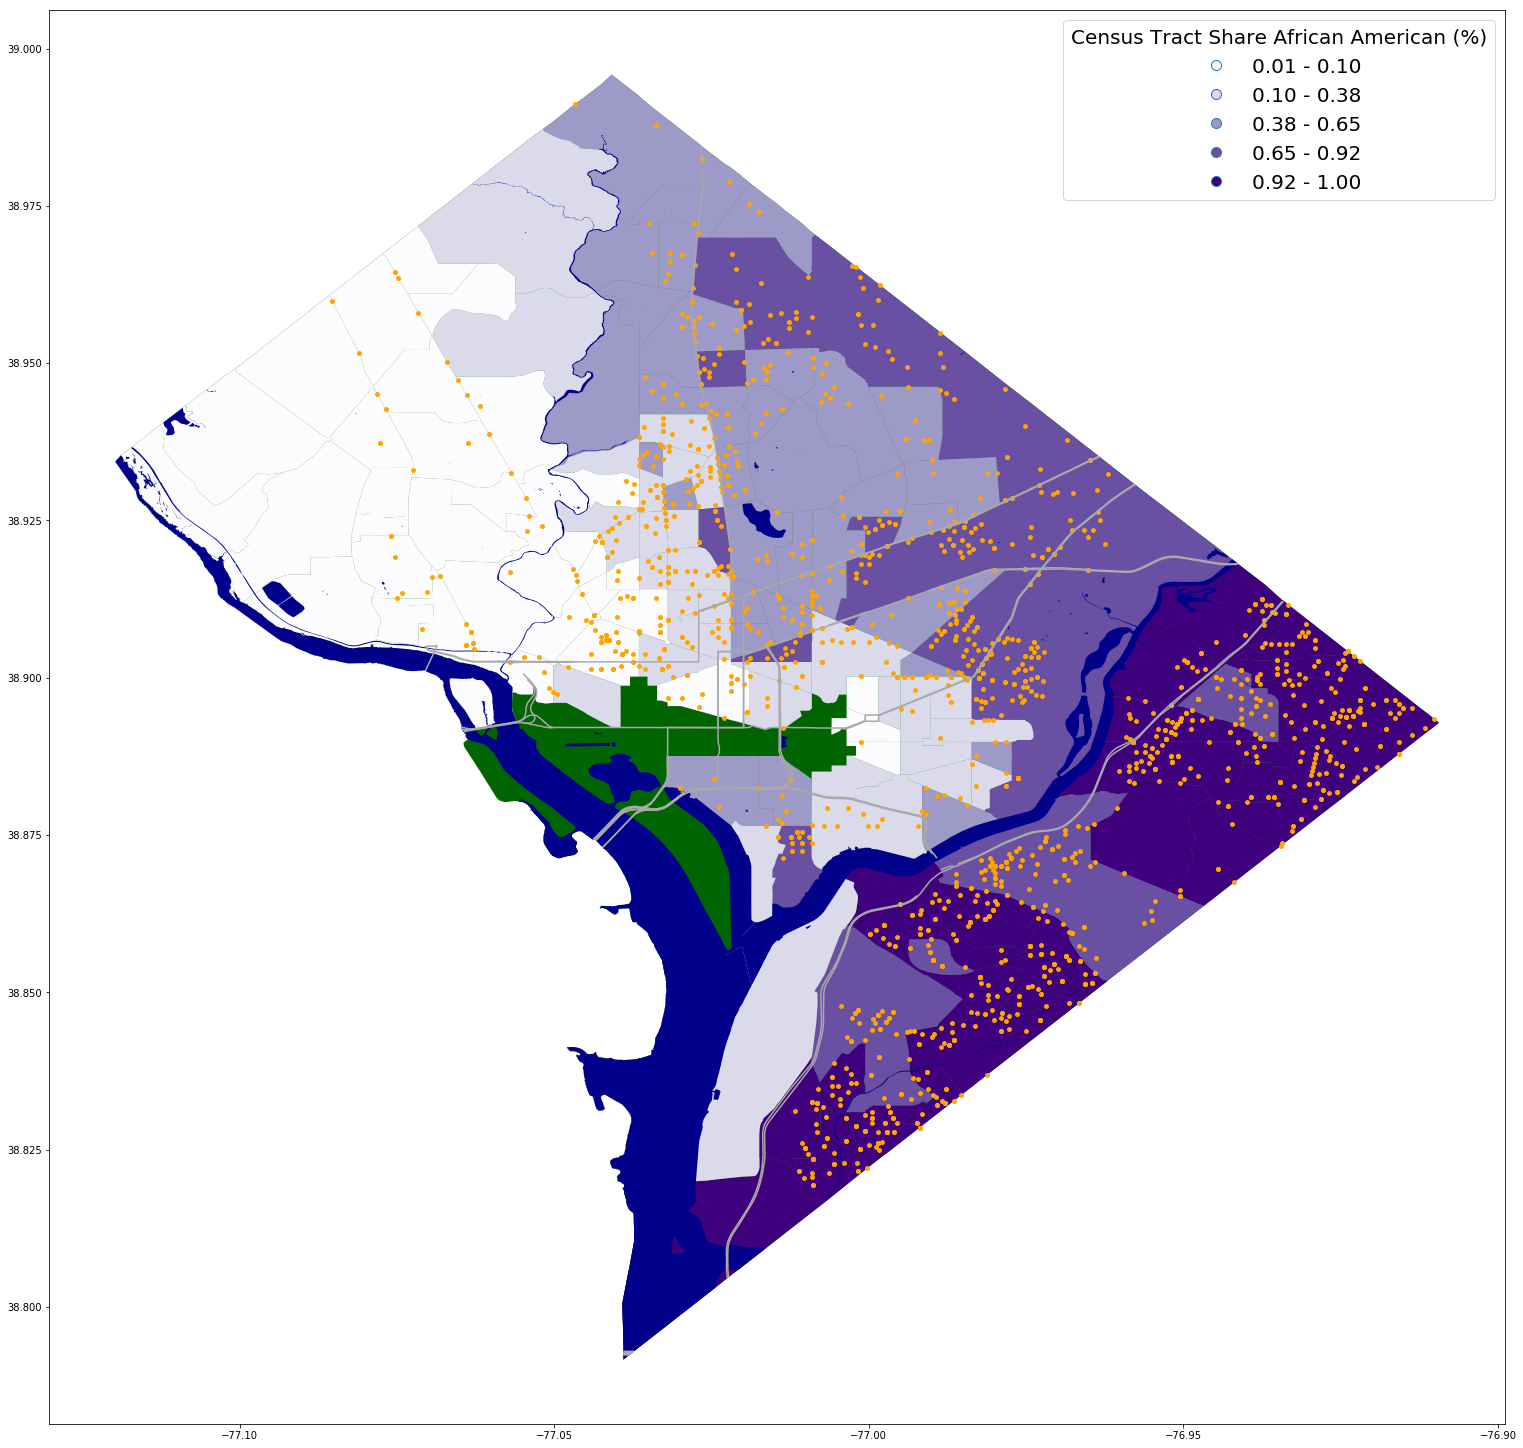

In [95]:
%matplotlib inline
base        = crimeratemap.plot(color='darkgreen',figsize=(40,26))
race_layer = crimeratemap_dropmall.plot(ax=base,column='shareblack',cmap='Purples',scheme='quantiles',k=5,legend=True,
                                       legend_kwds={'loc': 1,'title':'Census Tract Share African American (%)',  'prop':{'size':20}})                                                   
water_layer = dcwatermap.plot(ax=race_layer,color='darkblue',figsize=(40,26))
road_layer  = dcroadmap.plot(ax=water_layer,color='darkgrey',figsize=(40,26))

geo_assaultweaponpts.plot(ax=road_layer, marker="o", markersize=15, color='orange', figsize=(40,26))
leg = race_layer.get_legend()
plt.setp(leg.get_title(), multialignment='left', size=20)
plt.show()